# Introduction
This report presents a demo analysis of retail transaction data to showcase several foundational techniques for extracting actionable insights from customer, product, and sales information. The goal is to illustrate how raw transaction data can be transformed into meaningful visualizations and metrics that support data-driven decision-making.

What you're looking at is not a full production analytics suite, but rather a curated walkthrough of some key analytical perspectives, including:

Sales trends over time

Top-performing stores and discount strategies

Customer segmentation using RFM modeling and clustering

Product category performance comparisons

The relationship between discounts and sales volume

Each chart or table is designed to answer a specific business question—such as who are our best customers?, which stores are the most effective?, or how much are we discounting to drive revenue?

While this is a simplified demo, the techniques applied here—like KMeans clustering, time-series analysis, and categorical aggregation—can be extended into larger, more automated analytics pipelines.

In [1]:
# Import 
import json
import csv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast
import numpy as np


In [2]:
# Import Retail Data Set for Analysis
df = pd.read_csv('Data/Retail_Transaction_Dataset.csv', low_memory=False)

In [3]:
# Check Rows and columns
num_rows = df.shape[0]
num_cols = df.shape[1]

print(f'There are {num_rows} rows in the dataset')
print(f'There are {num_cols} columns in the dataset')

There are 100000 rows in the dataset
There are 10 columns in the dataset


In [4]:
# Check Column Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100000 non-null  int64  
 1   ProductID           100000 non-null  object 
 2   Quantity            100000 non-null  int64  
 3   Price               100000 non-null  float64
 4   TransactionDate     100000 non-null  object 
 5   PaymentMethod       100000 non-null  object 
 6   StoreLocation       100000 non-null  object 
 7   ProductCategory     100000 non-null  object 
 8   DiscountApplied(%)  100000 non-null  float64
 9   TotalAmount         100000 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


In [5]:
# There are no missing values.
missing = df. isnull().sum().sort_values(ascending=False)

# Get mostly_null by using the missing data * len of dataset. 
mostly_null = missing[missing > 0.50 * len(df)]
print('Columns with 50% missing values')
print(missing)

Columns with 50% missing values
CustomerID            0
ProductID             0
Quantity              0
Price                 0
TransactionDate       0
PaymentMethod         0
StoreLocation         0
ProductCategory       0
DiscountApplied(%)    0
TotalAmount           0
dtype: int64


In [6]:
# View Dataset
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CustomerID,109318,993229,579675,799826,121413,463050,888163,843385,839609,184135,266491,65632,26863,632732,798425,780621,633299,271379,246231,818911
ProductID,C,C,A,D,A,D,D,A,B,D,C,D,B,D,D,B,D,D,B,B
Quantity,7,4,8,5,7,3,7,8,5,4,8,8,3,6,5,2,8,6,2,5
Price,80.079844,75.195229,31.528816,98.880218,93.188512,54.093152,13.121937,56.025164,23.857981,63.342777,98.792726,78.123142,39.003285,45.47434,95.011762,19.91485,90.114673,16.707998,47.318685,77.090575
TransactionDate,12/26/2023 12:32,8/5/2023 0:00,3/11/2024 18:51,10/27/2023 22:00,12/22/2023 11:38,8/15/2023 4:24,12/26/2023 5:32,10/11/2023 6:48,2/27/2024 11:13,11/5/2023 1:46,9/25/2023 4:38,12/29/2023 5:07,12/27/2023 15:34,2/8/2024 8:03,10/27/2023 17:50,9/23/2023 18:51,2/28/2024 21:34,2/1/2024 2:35,4/28/2024 21:20,4/6/2024 18:59
PaymentMethod,Cash,Cash,Cash,PayPal,Cash,Cash,PayPal,Debit Card,Credit Card,Debit Card,Debit Card,PayPal,Credit Card,Cash,Cash,Cash,Credit Card,PayPal,Credit Card,Credit Card
StoreLocation,"176 Andrew Cliffs\nBaileyfort, HI 93354","11635 William Well Suite 809\nEast Kara, MT 19483","910 Mendez Ville Suite 909\nPort Lauraland, MO...","87522 Sharon Corners Suite 500\nLake Tammy, MO...","0070 Michelle Island Suite 143\nHoland, VA 80142","8492 Jonathan Drive\nNorth Robertshire, TN 67532",USNV Harrell\nFPO AA 62814,"489 Juan Loop Apt. 093\nNorth Brettville, WV 7...",528 Justin Expressway Apt. 336\nCabreraborough...,"189 Wright Mews\nMartinfurt, MO 75932","388 Matthew Lane Apt. 592\nWest Andreachester,...","PSC 1498, Box 4142\nAPO AP 10928","623 William Track Apt. 920\nPort Dave, NE 02045","5370 Nichols Fork Suite 983\nGeorgeshire, MT 2...","1573 Petty Parkway Apt. 835\nJordanmouth, IN 0...","419 Kerr Passage Apt. 443\nMartinezfort, MN 45678","1250 Gary Way Apt. 756\nSouth Thomasport, ND 3...","73061 Larry Pass Apt. 190\nFischerstad, PW 81056","103 Noah Court Apt. 298\nSouth Caseymouth, FM ...",44623 Elizabeth Throughway Apt. 440\nAmberview...
ProductCategory,Books,Home Decor,Books,Books,Electronics,Electronics,Clothing,Home Decor,Electronics,Books,Books,Electronics,Electronics,Books,Clothing,Clothing,Clothing,Clothing,Electronics,Books
DiscountApplied(%),18.6771,14.121365,15.943701,6.686337,4.030096,10.888768,16.295127,6.344306,18.703997,7.640607,14.174953,14.704311,14.368436,10.574618,16.248395,14.464678,15.174414,18.333591,6.9046,19.252574
TotalAmount,455.862764,258.306546,212.015651,461.343769,626.030484,144.609223,76.885907,419.766052,96.977925,234.012018,678.311227,533.085382,100.197369,243.993611,397.869376,34.068462,611.522396,81.868932,88.103039,311.243274


C:\Users\jdpic\AppData\Local\Temp\ipykernel_2108\2793802917.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(category_summary['ProductCategory'], rotation=45, ha='right')


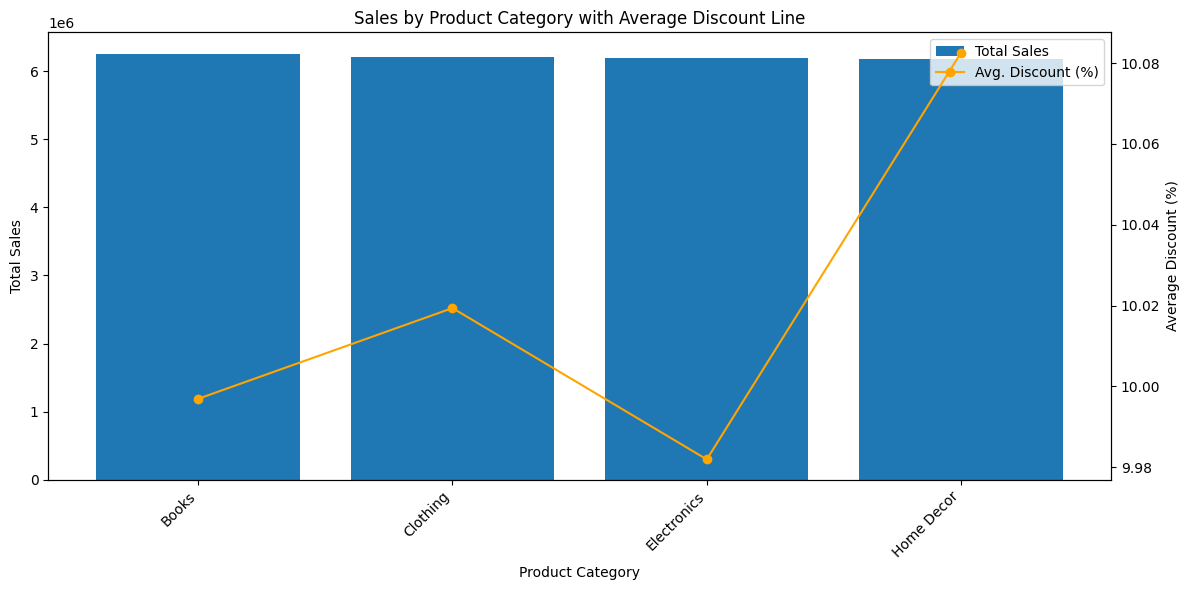

In [7]:
# Shows sales by product category and how discount applied to sales
import matplotlib.pyplot as plt

# Group by product category to get total sales and average discount
category_summary = df.groupby('ProductCategory').agg({
    'TotalAmount': 'sum',
    'DiscountApplied(%)': 'mean'
}).reset_index()

# Sort by total amount for better readability
category_summary.sort_values('TotalAmount', ascending=False, inplace=True)

# Create a bar and line chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for sales
bars = ax1.bar(category_summary['ProductCategory'], category_summary['TotalAmount'], label='Total Sales')
ax1.set_ylabel('Total Sales')
ax1.set_xlabel('Product Category')
ax1.set_xticklabels(category_summary['ProductCategory'], rotation=45, ha='right')
ax1.tick_params(axis='y')
ax1.set_title('Sales by Product Category with Average Discount Line')

# Line chart for discounts
ax2 = ax1.twinx()
ax2.plot(category_summary['ProductCategory'], category_summary['DiscountApplied(%)'], color='orange', marker='o', label='Avg. Discount (%)')
ax2.set_ylabel('Average Discount (%)')
ax2.tick_params(axis='y')

# Combine legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


### Chart Title: Sales by Product Category with Average Discount Line

This dual-axis visualization combines two key metrics to evaluate product category performance:

Blue Bars display total sales revenue by product category.

Orange Line represents the average discount percentage applied within each category.

Insights:
All four categories—Books, Clothing, Electronics, and Home Decor—achieved comparable total sales, indicating balanced category performance in revenue generation.

Home Decor had the highest average discount, suggesting more aggressive promotional tactics, possibly to drive demand or offload inventory.

Electronics, despite its competitive pricing potential, maintained the lowest average discount, which may point to strong brand or product-driven value perception.

Clothing shows a moderate discount strategy with solid revenue, indicating a possible sweet spot between promotional spend and sales volume.

Strategic Implications:
Consider reevaluating the effectiveness of high discounts in categories like Home Decor—are they essential, or could margin be preserved?

If Electronics can sustain sales with low discounts, that pricing power could be leveraged further in bundling or premium positioning.

Use this chart to inform category-specific pricing and promotion strategies, aligning margin protection with revenue growth.

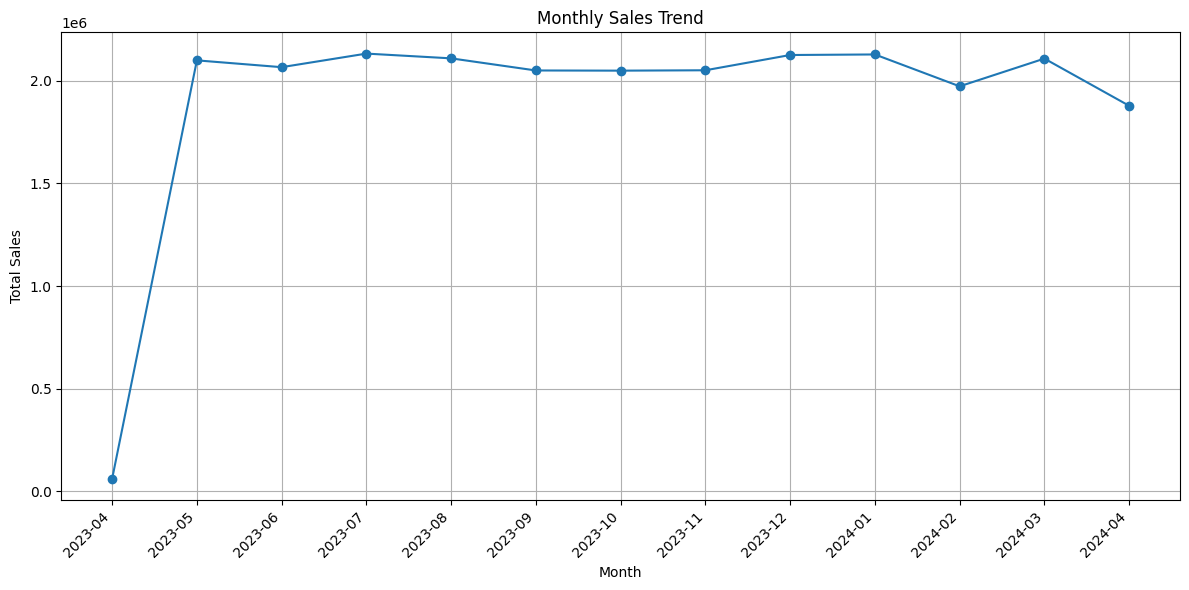

In [8]:
# Time base analysis

# convert TransactionDate to datetime for time-based analysis
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract year and month for aggregation
df['YearMonth'] = df['TransactionDate'].dt.to_period('M')

# Group by month to analyze sales trends over time
monthly_sales = df.groupby('YearMonth')['TotalAmount'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)  # convert back to string for plotting

# Plotting the sales trend over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['TotalAmount'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

### Chart Title: Monthly Sales Trend

This line chart displays total sales revenue by month over a one-year period, providing insight into temporal patterns and seasonality in retail performance.

Key Observations:
May 2023 through January 2024 maintained consistently high sales volume, averaging around $2 million per month.

A sharp jump in sales occurred between April and May 2023, suggesting the beginning of reliable transaction activity or possibly a campaign or launch.

February 2024 shows a noticeable dip, which could be due to seasonality (short month, post-holiday slowdown).

March 2024 rebounded strongly, while April 2024 again declined — a trend worth monitoring to determine if it's recurring.

Strategic Use:
Useful for identifying peak months and seasonal lulls, enabling demand forecasting and resource allocation.

Spikes or dips can be investigated in context of campaigns, holidays, or market events.

Forms a foundational view for more advanced time-series forecasting or promotion planning.

C:\Users\jdpic\AppData\Local\Temp\ipykernel_2108\1644425090.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_stores['StoreLocation'], rotation=45, ha='right')


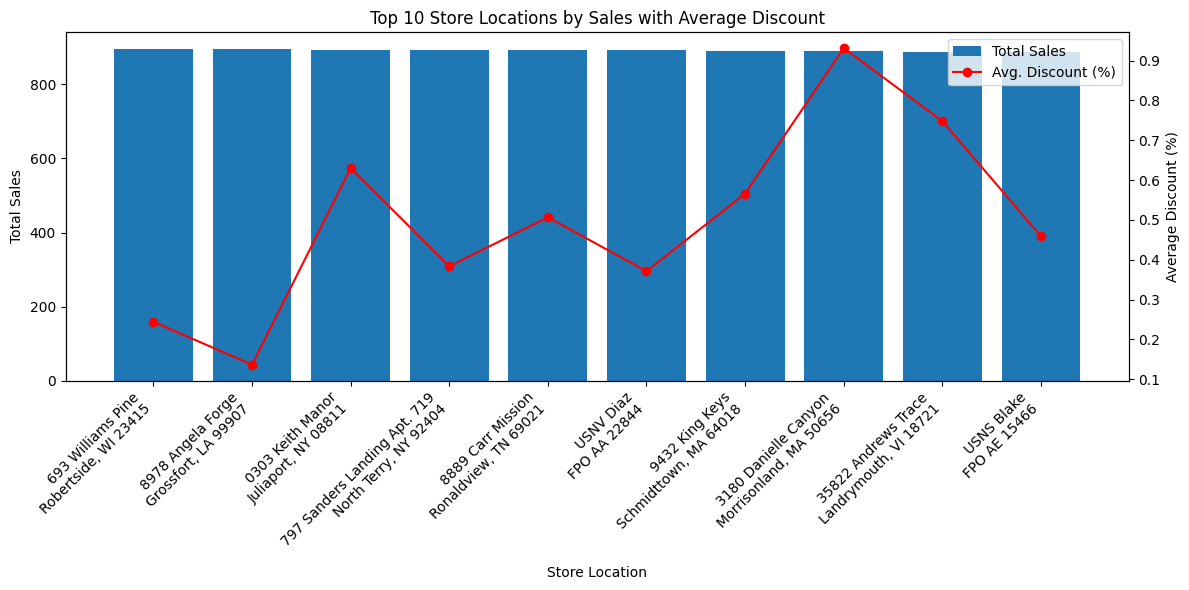

In [9]:
# Grouping by StoreLocation to calculate total sales and average discount
store_performance = df.groupby('StoreLocation').agg({
    'TotalAmount': 'sum',
    'DiscountApplied(%)': 'mean',
    'CustomerID': 'nunique'  # approximate foot traffic
}).rename(columns={
    'TotalAmount': 'TotalSales',
    'DiscountApplied(%)': 'AvgDiscount',
    'CustomerID': 'UniqueCustomers'
}).reset_index()

# Sort by total sales and show top 10 stores
top_stores = store_performance.sort_values(by='TotalSales', ascending=False).head(10)

# Plotting top 10 store sales with average discount
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top_stores['StoreLocation'], top_stores['TotalSales'], label='Total Sales')
ax1.set_ylabel('Total Sales')
ax1.set_xlabel('Store Location')
ax1.set_xticklabels(top_stores['StoreLocation'], rotation=45, ha='right')
ax1.tick_params(axis='y')
ax1.set_title('Top 10 Store Locations by Sales with Average Discount')

# Overlay average discount line
ax2 = ax1.twinx()
ax2.plot(top_stores['StoreLocation'], top_stores['AvgDiscount'], color='red', marker='o', label='Avg. Discount (%)')
ax2.set_ylabel('Average Discount (%)')
ax2.tick_params(axis='y')

# Combine legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

### Chart Title: Top 10 Store Locations by Sales with Average Discount

This dual-axis chart presents the top 10 retail store locations ranked by total sales, alongside the average discount percentage applied at each location.

Blue Bars represent the total sales per store. Each store has similar sales volumes, indicating consistent performance across the top tier.

Red Line plots the average discount (%) offered by each location. This highlights differences in promotional strategy.

Key observations:

The highest-discounting store (35B22 Andrews Trace, Landrymouth, VI) stands out with an average discount close to 1%, while still maintaining top-tier sales—suggesting successful use of discounting to drive volume.

Several high-performing stores (e.g., 0303 Keith Manor, Juliaport, NY) achieve similar sales with significantly lower discount rates, potentially indicating stronger brand or location-driven demand.

The variability in discount rates suggests opportunities for pricing optimization and more tailored promotional strategies by region.

This chart supports strategic decisions around store-level discounting policies, promotion effectiveness, and localized sales optimization.

C:\Users\jdpic\AppData\Local\Temp\ipykernel_2108\3076011563.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(category_detail['ProductCategory'], rotation=45, ha='right')


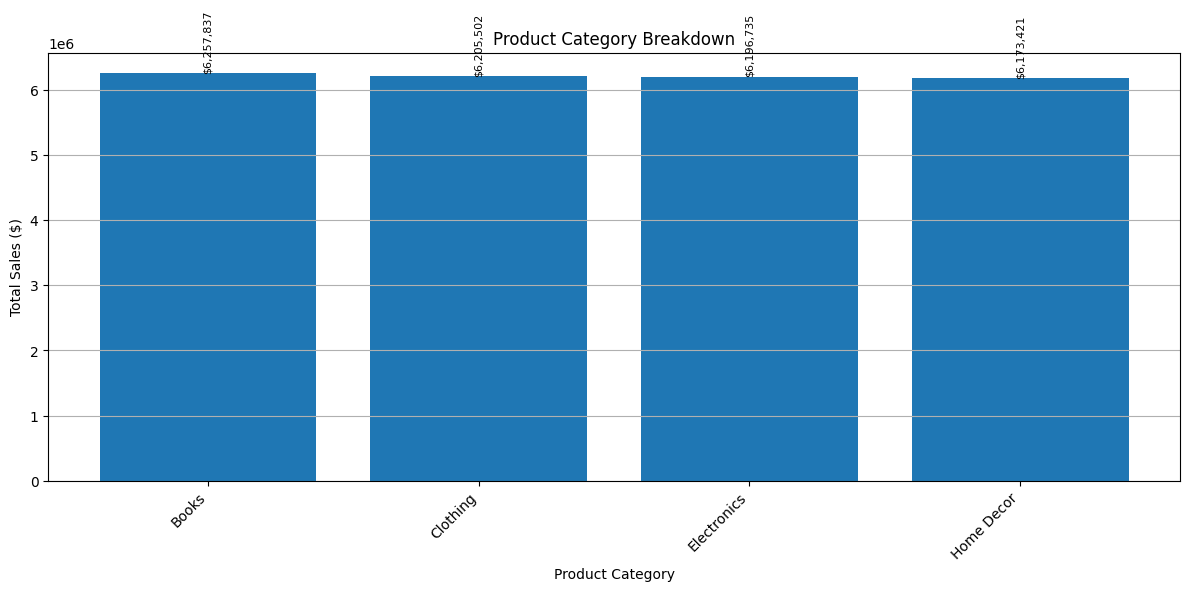

In [10]:
# Grouping by ProductCategory to get deeper breakdown
category_detail = df.groupby('ProductCategory').agg({
    'TotalAmount': ['sum', 'mean'],
    'Quantity': ['sum', 'mean'],
    'DiscountApplied(%)': 'mean'
})

# Flatten multi-level columns
category_detail.columns = ['TotalSales', 'AvgSalesPerTransaction', 'TotalUnitsSold', 'AvgUnitsPerTransaction', 'AvgDiscount']
category_detail = category_detail.reset_index()

# Sort by total sales
category_detail.sort_values(by='TotalSales', ascending=False, inplace=True)

# Visualize with a bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar = ax.bar(category_detail['ProductCategory'], category_detail['TotalSales'], label='Total Sales')

# Annotate bars
for i, val in enumerate(category_detail['TotalSales']):
    ax.text(i, val, f"${val:,.0f}", ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_title('Product Category Breakdown')
ax.set_ylabel('Total Sales ($)')
ax.set_xlabel('Product Category')
ax.set_xticklabels(category_detail['ProductCategory'], rotation=45, ha='right')
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

#import ace_tools as tools; tools.display_dataframe_to_user(name="Detailed Product Category Breakdown", dataframe=category_detail)


### Chart Title: Product Category Breakdown

This bar chart presents the total sales revenue by product category, highlighting how revenue is distributed across the store’s main merchandise lines: Books, Clothing, Electronics, and Home Decor.

Key Observations:
All four categories generated remarkably similar total sales, each exceeding $6.1 million, suggesting a well-balanced product portfolio.

Books narrowly led in total sales, followed closely by Clothing and Electronics, while Home Decor came in just behind.

The minimal variation in revenue suggests that no single category dominates, which may indicate:

Effective cross-category promotion,

Balanced inventory investment,

Or a diversified customer demand profile.

Strategic Takeaway:
This balance is a strength, reducing overreliance on any one product line.

However, more granular analysis (e.g., margin, units sold, or profit contribution) could reveal whether some categories are outperforming in profitability, not just revenue.

Consider drilling down into subcategory or product-level performance to identify hidden opportunities or inefficiencies.

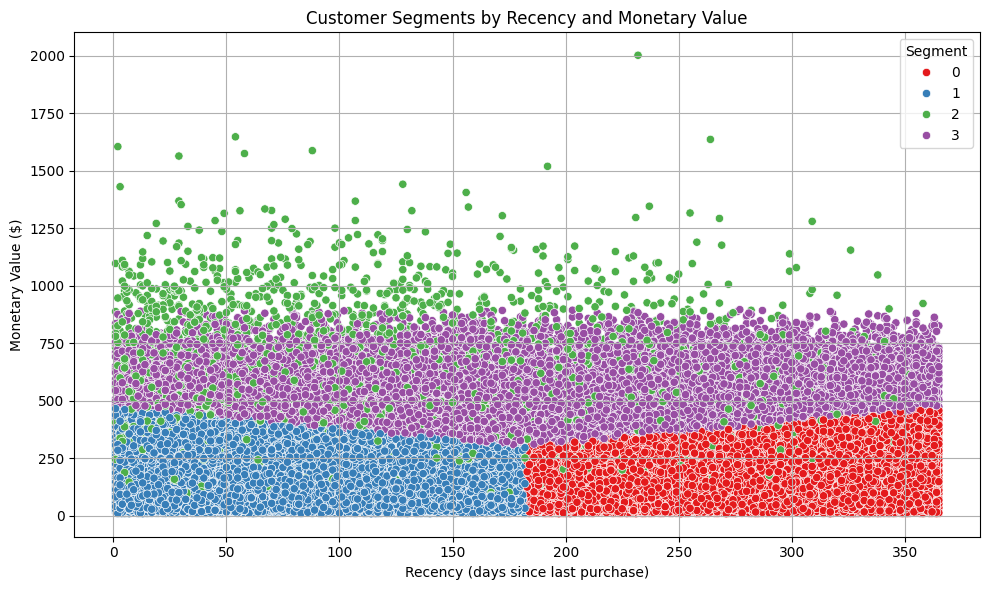

In [11]:
# Step 1: Create an RFM (Recency, Frequency, Monetary) table

# Reference date for recency (most recent transaction in data + 1 day)
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

# Group by customer
rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'CustomerID': 'count',  # Frequency
    'TotalAmount': 'sum'    # Monetary
}).rename(columns={
    'TransactionDate': 'Recency',
    'CustomerID': 'Frequency',
    'TotalAmount': 'Monetary'
}).reset_index()

# Step 2: Perform KMeans clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

# Step 3: Plot clusters
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set1')
plt.title('Customer Segments by Recency and Monetary Value')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary Value ($)')
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

### Chart Title: Customer Segments by Recency and Monetary Value

Step 1: Create an RFM (Recency, Frequency, Monetary) table
Reference date for recency (most recent transaction in data + 1 day)
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

Group by customer
rfm = df.groupby('CustomerID').agg({ 'TransactionDate': lambda x: (snapshot_date - x.max()).days, # Recency 'CustomerID': 'count', # Frequency 'TotalAmount': 'sum' # Monetary }).rename(columns={ 'TransactionDate': 'Recency', 'CustomerID': 'Frequency', 'TotalAmount': 'Monetary' }).reset_index()

Step 2: Perform KMeans clustering
from sklearn.preprocessing import StandardScaler from sklearn.cluster import KMeans

Scale the data
scaler = StandardScaler() rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

Step 3: Plot clusters
import seaborn as sns import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set1') plt.title('Customer Segments by Recency and Monetary Value') plt.xlabel('Recency (days since last purchase)') plt.ylabel('Monetary Value ($)') plt.legend(title='Segment') plt.grid(True) plt.tight_layout() plt.show()